In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline
import jax
import jax.numpy as np
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfd = tfp.distributions
from nsec.samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm
from nsec.datasets.two_moons import get_two_moons
from nsec.tempered_sampling import TemperedMC

Populating the interactive namespace from numpy and matplotlib


In [2]:
from functools import partial

def logp(x, sigma):
    return get_two_moons(sigma+0.02).log_prob(x).squeeze()

dlogp = jax.jit(jax.grad(logp))

In [3]:
def score_fn(x, sigma):
    @partial(jax.vmap, in_axes=(0,0))
    def inner_fn(x, sigma):
        return dlogp(x, sigma)
    return inner_fn(x, sigma)

In [4]:
logp(np.zeros([10,1,2]).astype('float32'),
      np.ones([10,1,1]).astype('float32')).shape

/home/francois/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/francois/.local/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1674: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


(10,)

In [5]:
score_fn(np.zeros([10,2]).astype('float32'),
      np.ones([10]).astype('float32')).shape

(10, 2)

In [162]:
def make_kernel_fn(target_log_prob_fn, target_score_fn):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=0.01,
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

In [204]:
tmc = TemperedMC(
    target_score_fn=score_fn,
    inverse_temperatures=np.ones([10]),
    make_kernel_fn=make_kernel_fn,
    gamma=0.7,
    min_steps_per_temp=20,
    num_delta_logp_steps=4)

In [205]:
num_results = int(1e3)
num_burnin_steps = int(1)

In [206]:
samples, trace = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=np.zeros([10,2])+randn(10,2),
        kernel=tmc,
        num_burnin_steps=num_burnin_steps,
        #trace_fn=lambda _, pkr: pkr.pre_swap_replica_results.is_accepted,
        seed=jax.random.PRNGKey(0))

/home/francois/.local/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/_jax/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


[Traced<ShapedArray(float32[10,2]):JaxprTrace(level=1/0)>]


In [207]:
trace.post_tempering_inverse_temperatures.shape

(1000, 10)

In [208]:
trace.pre_tempering_results.is_accepted

DeviceArray([[ True,  True,  True, ...,  True,  True,  True],
             [ True,  True,  True, ...,  True,  True,  True],
             [ True,  True,  True, ...,  True,  True,  True],
             ...,
             [ True,  True,  True, ...,  True,  True,  True],
             [ True,  True,  True, ...,  True,  True,  True],
             [ True,  True,  True, ..., False,  True,  True]], dtype=bool)

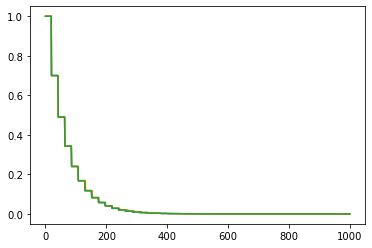

In [209]:
plot(trace.post_tempering_inverse_temperatures[:,0])
plot(trace.post_tempering_inverse_temperatures[:,1])
plot(trace.post_tempering_inverse_temperatures[:,2])

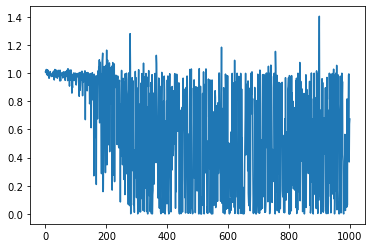

In [210]:
plot(np.exp(trace.tempering_log_accept_ratio[:,0]))

In [211]:
samples.shape

(1000, 10, 2)

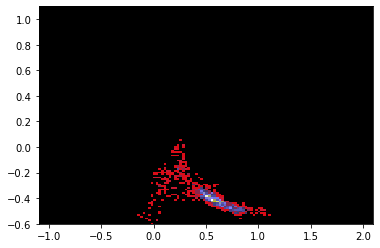

In [212]:
hist2d(samples[:,0,0],samples[:,0,1],128,
       range=[[-1.1,2.1],[-0.6,1.1]],cmap='gist_stern');

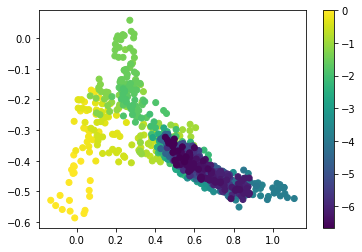

In [213]:
scatter(samples[:,0,0],samples[:,0,1], c=log10(trace.post_tempering_inverse_temperatures[:,0])); colorbar()

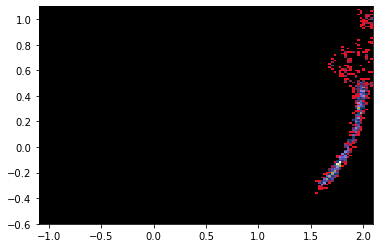

In [214]:
hist2d(samples[:,1,0],samples[:,1,1],128,
       range=[[-1.1,2.1],[-0.6,1.1]],cmap='gist_stern');

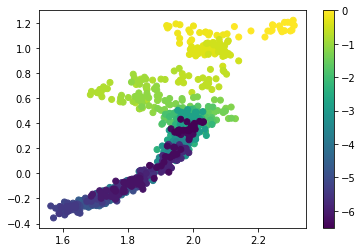

In [215]:
scatter(samples[:,1,0],samples[:,1,1], c=log10(trace.post_tempering_inverse_temperatures[:,1])); colorbar()

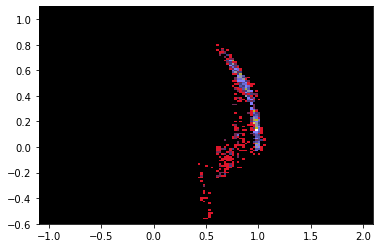

In [216]:
hist2d(samples[:,2,0],samples[:,2,1],128,
       range=[[-1.1,2.1],[-0.6,1.1]],cmap='gist_stern');

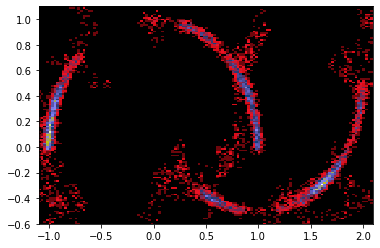

In [217]:
hist2d(samples[:,:,0].flatten(),samples[:,:,1].flatten(),128,
       range=[[-1.1,2.1],[-0.6,1.1]],cmap='gist_stern');

ValueError: too many values to unpack (expected 2)

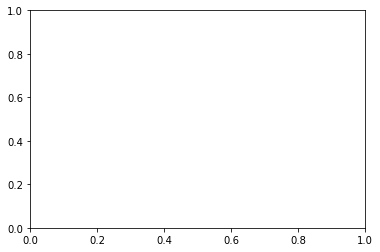

In [203]:
hist2d(samples[:,0],samples[:,1],128,
       range=[[-1.1,2.1],[-0.6,1.1]],cmap='gist_stern');

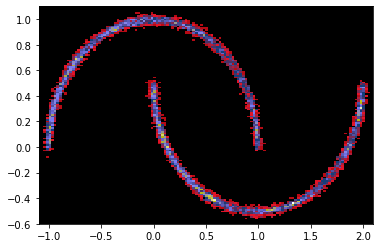

In [9]:
hist2d(samples[:,0],samples[:,1],128,
       range=[[-1.1,2.1],[-0.6,1.1]],cmap='gist_stern');

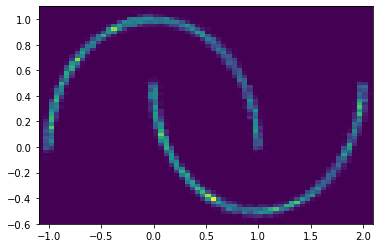

In [15]:
hist2d(samples[:,0],samples[:,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);

In [ ]:
def make_replica_target_log_prob_fn(log_prob_fn, inverse_temp):
    def fn(x):
        y = log_prob_fn(x) * inverse_temp
    return fn

In [10]:
def make_kernel_fn(target_log_prob_fn, target_score_fn):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=step_size, 
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

In [11]:
remc = ReplicaExchangeMC(
    target_score_fn=score_fn,
    inverse_temperatures=sigmas,
    make_kernel_fn=make_kernel_fn,
    num_delta_logp_steps=32)

In [12]:
def trace_swaps(unused_state, results):
  return (results.is_swap_proposed_adjacent,
          results.is_swap_accepted_adjacent)

In [13]:
num_results = int(1e4)
num_burnin_steps = int(1e2)

In [14]:
samples, trace = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=np.zeros([1,2]),
        kernel=remc,
        num_burnin_steps=num_burnin_steps,
        trace_fn=lambda _, pkr: pkr.pre_swap_replica_results.is_accepted,
        seed=jax.random.PRNGKey(0))

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:6193: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:6193: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [15]:
[len(where(trace[:,i,0])[0]) for i in range(4)]

[9268, 9735, 9923, 9985]

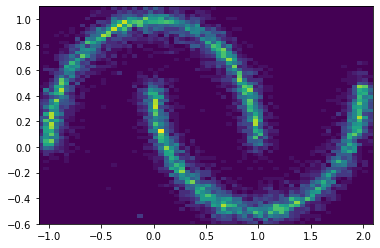

In [16]:
hist2d(samples[:,0,0],samples[:,0,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);

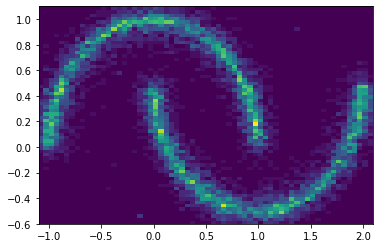

In [17]:
hist2d(samples[:,0,0],samples[:,0,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);

In [32]:
dist_target=get_two_moons(sigmas[0]+0.02)

In [33]:
samps = dist_target.sample(10000, seed=jax.random.PRNGKey(0))

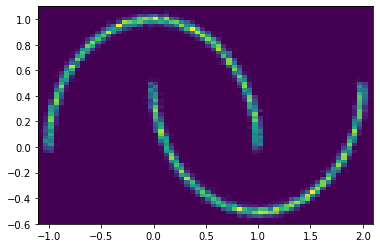

In [34]:
hist2d(samps[:,0],samps[:,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);

In [24]:
# And just to compare, what would have happened if we only ran a normal
# HMC in the same conditions
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=dist_target.log_prob,
    num_leapfrog_steps=3,
    step_size=0.0125)

In [25]:
samples_hmc, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=np.zeros([1,2]),
      kernel=hmc,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(0))

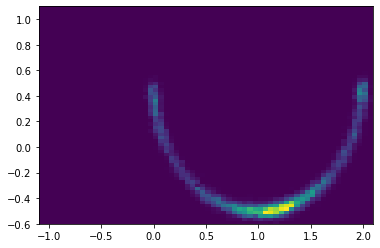

In [26]:
hist2d(samples_hmc[:,0,0],samples_hmc[:,0,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);